### Import's

In [11]:
import pandas as pd
import statistics
from collections import Counter
import matplotlib.pyplot as plt
import json
import string
import glob
import numpy as np
import seaborn as sns 
from scipy.stats import kurtosis
from scipy.stats import skew
from collections import Counter

### Lendo arquivo csv

In [12]:
data_path = "./*.csv"
files_Lists = glob.glob (data_path)
print('Quantidade de planilhas:', len(files_Lists))
files_Lists 

Quantidade de planilhas: 1


['.\\dataset_rotulado.csv']

In [13]:
dataFrames_Lists = []
def cria_DataFrames(files_Lists, dataFrames_Lists):    
    for f in files_Lists:
        csv = pd.read_csv(f) 
        csv.drop(columns = ['Unnamed: 0'], inplace=True)
        dataFrames_Lists.append(csv) 
    print('Quantidade de datasets:',len(dataFrames_Lists))

In [14]:
cria_DataFrames(files_Lists,dataFrames_Lists)

Quantidade de datasets: 1


#### Pegando as linhas referentes as pontuações, para removelas do dataset

#### Função para retirar a marcação IOB

In [20]:
#Tem a função de retirar o I-rotulo e B-rotulo para visualização crua dos rotulos
## Recebe uma lista de rotulações no formato IOB e devolve uma lista com as rotulações sem o formato IOB
def retira_IOB(lista_rotulacoes):
    dict_rotulacoes = dict({})
    for dado in lista_rotulacoes:
        if dado[0] != 'O':
            if dado[0][2:] not in dict_rotulacoes.keys():
                dict_rotulacoes.update(dict({dado[0][2:] : 0}))
            dict_rotulacoes[dado[0][2:]] += dado[1]
        else:
            dict_rotulacoes[dado[0]] = dado[1]
    return list(dict_rotulacoes.items()) ## Quantidades de vezes que cada entidade apareceu na lista original
## Função para contabilizar a quantidade de vezes que a entidade aparece na lista com as rotulações em formato IOB
def contabiliza_rotulos(lista_rotulacoes):
    dict_rotulacoes = dict({})
    for dado in lista_rotulacoes:
        if dado[0][:2] == 'B-' and dado[0] != 'O':
            if dado[0][2:] not in dict_rotulacoes.keys():
                dict_rotulacoes.update(dict({dado[0][2:] : 0}))
            dict_rotulacoes[dado[0][2:]] += dado[1]
        elif dado[0] == 'O':
            dict_rotulacoes[dado[0]] = dado[1]
    return list(dict_rotulacoes.items()) 

## Preparando os dados para pegar a quantidade de tokens por setença
def func_lista_tokens_por_sentenca(df_original):
    lista_tokens_por_sentenca = list(df_original.groupby(by="Sentenca")["Palavras"].count()) ## Agrupa as sentenças, e contabiliza quantos tokens tem por setença e transforma essa contagem em lista
    return lista_tokens_por_sentenca
#lista_tokens_por_sentenca

## Pegando informações de token por instância
def func_lista_tokens_por_inst(df_original):
    lista_tokens_por_inst = list(df_original.groupby(by='Documento')['Palavras'].count())
    return lista_tokens_por_inst
#lista_tokens_por_inst

## Pegando informações de sentenças por instância
lista_sentencas_por_inst = []
def func_lista_sentencas_por_inst(df_original):
    for dado in df_original.groupby(by='Documento')['Sentenca']:
        lista_sentencas_por_inst.append(len(Counter(list(dado[1])).keys()))
    return lista_sentencas_por_inst
#lista_sentencas_por_inst

## Preparando para pegar as quantidades de rotulações existente em todo dataset, a variavel guarda o total de rotulações por token em todo o dataset
def func_lista_qtdRotulacoes_IOB_por_token(df_original):
    lista_qtdRotulacoes_IOB_por_token = [[x[0], x[1]["Palavras"].count()] for x in df_original.groupby(by="Rotulo")] ## Agrupa por rotulação e calcucula quantos tokens tem por rotulação
    return lista_qtdRotulacoes_IOB_por_token
## A varivel guarda o total de rotulações por token em todo data set sem o formato IOB
def func_lista_qtdRotulacoes_por_token(df_original):
    lista_qtdRotulacoes_IOB_por_token=func_lista_qtdRotulacoes_IOB_por_token(df_original)
    lista_qtdRotulacoes_por_token = retira_IOB(lista_qtdRotulacoes_IOB_por_token)
    return lista_qtdRotulacoes_por_token
## A variavel guarda apenas as quantidade de categoria de entidades rotuladas em todo o dataset
def func_lista_qtdRotulacoes(df_original):
    lista_qtdRotulacoes_IOB_por_token=func_lista_qtdRotulacoes_IOB_por_token(df_original)
    lista_qtdRotulacoes = contabiliza_rotulos(func_lista_qtdRotulacoes_IOB_por_token(df_original))
    return lista_qtdRotulacoes

## Preparando para pegar rotulações por sentença de todo dataset
def func_lista_rotulos_por_sentenca_IOB_por_token(df_original):
    lista_rotulos_por_sentenca_IOB_por_token = []
    for dado in df_original.groupby(by="Sentenca"):
        lista_rotulos_por_sentenca_IOB_por_token.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])
    return lista_rotulos_por_sentenca_IOB_por_token  
## Cria uma versão da lista sem os marcadores do formato IOB
def func_lista_rotulos_por_sentenca_por_token(df_original):
    lista_rotulos_por_sentenca_IOB_por_token = func_lista_rotulos_por_sentenca_IOB_por_token(df_original)
    lista_rotulos_por_sentenca_por_token = []
    for sentenca in lista_rotulos_por_sentenca_IOB_por_token:
        lista_rotulos_por_sentenca_por_token.append([sentenca[0], retira_IOB(sentenca[1])])
    return lista_rotulos_por_sentenca_por_token
## Extrai a quantidade de categoria de entidades rotuladas em cada sentença de todo o dataset
def func_lista_rotulos_por_sentenca(df_original):
    lista_rotulos_por_sentenca_IOB_por_token = func_lista_rotulos_por_sentenca_IOB_por_token(df_original)
    lista_rotulos_por_sentenca = []
    for sentenca in lista_rotulos_por_sentenca_IOB_por_token:
        lista_rotulos_por_sentenca.append([sentenca[0], contabiliza_rotulos(sentenca[1])])
    return lista_rotulos_por_sentenca

## Preparando para pegar rotulações por instância de todo dataset
def func_lista_rotulacoes_por_inst_IOB_por_token(df_original):
    lista_rotulacoes_por_inst_IOB_por_token = []
    for dado in df_original.groupby(by="Documento"):
        lista_rotulacoes_por_inst_IOB_por_token.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])
    return lista_rotulacoes_por_inst_IOB_por_token
## Preparando para extrair rotulações por instância sem IOB
def func_lista_rotulacoes_por_inst_por_token(df_original):
    lista_rotulacoes_por_inst_IOB_por_token = func_lista_rotulacoes_por_inst_IOB_por_token(df_original)
    lista_rotulacoes_por_inst_por_token = []
    for instancia in lista_rotulacoes_por_inst_IOB_por_token:
        lista_rotulacoes_por_inst_por_token.append([instancia[0], retira_IOB(instancia[1])])
    return lista_rotulacoes_por_inst_por_token
## Extrai a quantidade de categoria de entidades rotuladas em cada instância
def func_lista_rotulacoes_por_inst(df_original):
    lista_rotulacoes_por_inst_IOB_por_token = func_lista_rotulacoes_por_inst_IOB_por_token(df_original)
    lista_rotulacoes_por_inst = []
    for instancia in lista_rotulacoes_por_inst_IOB_por_token:
        lista_rotulacoes_por_inst.append([instancia[0], contabiliza_rotulos(instancia[1])])
    return lista_rotulacoes_por_inst

## Preparando para pegar rotulações por token
def func_lista_rotulacoes_por_tokens_IOB(df_original):
    lista_rotulacoes_por_tokens_IOB = []
    for dado in df_original.groupby(by="Palavras"):
        lista_rotulacoes_por_tokens_IOB.append([dado[0], list(Counter(list(dado[1]["Rotulo"])).items())])
    return lista_rotulacoes_por_tokens_IOB
## Preparando para extrair rotulações por token sem IOB
def func_lista_rotulacoes_por_tokens(df_original):
    lista_rotulacoes_por_tokens_IOB = func_lista_rotulacoes_por_tokens_IOB(df_original)
    lista_rotulacoes_por_tokens = []
    for token in lista_rotulacoes_por_tokens_IOB:
        lista_rotulacoes_por_tokens.append([token[0], retira_IOB(token[1])])
    return lista_rotulacoes_por_tokens

### Aplicando a função ao dataset

In [24]:
lista_tokens_por_sentenca=func_lista_tokens_por_sentenca(dataFrames_Lists[0])
lista_tokens_por_inst=func_lista_tokens_por_inst(dataFrames_Lists[0])
lista_sentencas_por_inst = func_lista_sentencas_por_inst(dataFrames_Lists[0])
lista_qtdRotulacoes_IOB_por_token=func_lista_qtdRotulacoes_IOB_por_token(dataFrames_Lists[0])
lista_qtdRotulacoes_por_token=func_lista_qtdRotulacoes_por_token(dataFrames_Lists[0])
lista_qtdRotulacoes=func_lista_qtdRotulacoes(dataFrames_Lists[0])
lista_rotulos_por_sentenca_IOB_por_token = func_lista_rotulos_por_sentenca_IOB_por_token(dataFrames_Lists[0])
lista_rotulos_por_sentenca=func_lista_rotulos_por_sentenca(dataFrames_Lists[0])
lista_rotulacoes_por_inst_IOB_por_token=func_lista_rotulacoes_por_inst_IOB_por_token(dataFrames_Lists[0])
lista_rotulacoes_por_inst_por_token=func_lista_rotulacoes_por_inst_por_token(dataFrames_Lists[0])
lista_rotulacoes_por_inst=func_lista_rotulacoes_por_inst(dataFrames_Lists[0])
lista_rotulacoes_por_tokens_IOB=func_lista_rotulacoes_por_tokens_IOB(dataFrames_Lists[0])
lista_rotulacoes_por_tokens=func_lista_rotulacoes_por_tokens(dataFrames_Lists[0])

### Estatísticas

Dados Demográficos do Dataset cachacaNER

In [25]:
print("-----QUANTIDADES-----")
print("Quantidade de documentos: " + str(len(lista_tokens_por_inst)))
print("Quantidade de sentenças: " + str(len(lista_tokens_por_sentenca)))
print("Quantidade de tokens: " + str(len(dataFrames_Lists[0])))

-----QUANTIDADES-----
Quantidade de documentos: 1000
Quantidade de sentenças: 13628
Quantidade de tokens: 183019


In [26]:
lista_qtdRotulacoes = sorted(lista_qtdRotulacoes, key=lambda i: i[-1])
lista_qtdRotulacoes

[('CARACTERISTICA_SENSORIAL_CONSISTÊNCIA', 278),
 ('EQUIPAMENTO_DESTILACAO', 292),
 ('CARACTERISTICA_SENSORIAL_COR', 562),
 ('NOME_PESSOA', 743),
 ('PRECO', 885),
 ('CARACTERISTICA_SENSORIAL_SABOR', 906),
 ('CARACTERISTICA_SENSORIAL_AROMA', 935),
 ('NOME_ORGANIZACAO', 974),
 ('RECIPIENTE_ARMAZENAMENTO', 991),
 ('GRADUACAO_ALCOOLICA', 1144),
 ('TEMPO_ARMAZENAMENTO', 1210),
 ('TEMPO', 1302),
 ('CLASSIFICACAO_BEBIDA', 1325),
 ('VOLUME', 2532),
 ('TIPO_MADEIRA', 2557),
 ('NOME_BEBIDA', 3171),
 ('NOME_LOCAL', 4232),
 ('O', 143805)]

#### Gráficos com informações sobre as Categorias

Quantidade de rotulações por categoria sem IOB

Total de tokens não rotulados: 143805


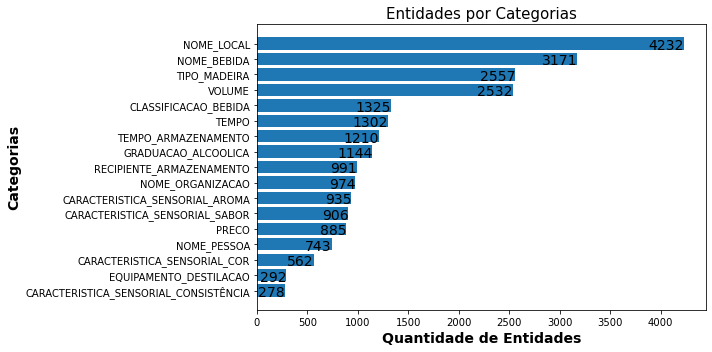

In [218]:
import os        
lista_aux = [x for x in lista_qtdRotulacoes if x[0] != 'O']
valor_O = [x[1] for x in lista_qtdRotulacoes if x[0] == 'O']
print("Total de tokens não rotulados: " + str(valor_O[0]))

grupos = [x[0] for x in lista_aux]
valores = [x[1] for x in lista_aux]
#plt.subplots(1,1, figsize=(7,5))
plt.figure(figsize = (10,5))
plt.barh(grupos, valores)


for index, item in enumerate(valores):
    plt.text(valores[index],index,valores[index],  va="center_baseline",ha="right",fontsize=14)
    
plt.title('Entidades por Categorias',fontsize=15)
plt.xlabel('Quantidade de Entidades', fontweight='bold', fontsize=14.0)
plt.ylabel('Categorias', fontweight='bold', fontsize=14.0)
plt.savefig(os.path.join('25.png'), dpi=300, format='png', bbox_inches='tight') 
plt.show()

### TOKENS POR SENTENÇA

In [34]:
print('-------TOKENS POR SENTENÇAS-----------')
print("-----QUANTIDADES-----")
print("Quantidade de sentenças: " + str(len(lista_tokens_por_sentenca)))
print("Quantidade de tokens: " + str(sum(lista_tokens_por_sentenca)))
print("Quantidade máxima de tokens em uma sentença: " + str(max(lista_tokens_por_sentenca)))
print("Quantidade mínima de tokens em uma sentença: " + str(min(lista_tokens_por_sentenca)))
print("-----Médias-----")
print("Média aritmética dos tokens por sentença: " + str(statistics.mean(lista_tokens_por_sentenca)))
print("Média geométrica dos tokens por sentença: " + str(statistics.geometric_mean(lista_tokens_por_sentenca)))
print("Média harmônica dos tokens por sentença: " + str(statistics.harmonic_mean(lista_tokens_por_sentenca)))
print("-----Medianas-----")
print("Mediana dos tokens por setença: " + str(statistics.median(lista_tokens_por_sentenca)))
print("Mediana inferior dos tokens por setença: " + str(statistics.median_low(lista_tokens_por_sentenca)))
print("Mediana superior dos tokens por setença: " + str(statistics.median_high(lista_tokens_por_sentenca)))
print("Mediana, ou o 50º percentil dos dados agrupados dos tokens por setença: " + str(statistics.median_grouped(lista_tokens_por_sentenca)))
print("-----Moda-----")
print("Moda dos tokens por sentença: " + str(statistics.mode(lista_tokens_por_sentenca)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional dos tokens por sentença: " + str(statistics.pstdev(lista_tokens_por_sentenca)))
print("Desvio padrão amostral dos tokens por sentença: " + str(statistics.stdev(lista_tokens_por_sentenca)))
print("-----Variância-----")
print("Variância populacional dos tokens por sentença: " + str(statistics.pvariance(lista_tokens_por_sentenca)))
print("Variância amostral dos tokens por sentença: " + str(statistics.variance(lista_tokens_por_sentenca)))
print("-----Quantiles-----")
print("Quantiles dos tokens por sentença: " + str(statistics.quantiles(lista_tokens_por_sentenca)))
print("Variancia dos tokens por sentença: " + str(statistics.variance(lista_tokens_por_sentenca)))
#print("Amplitude dos tokens por sentença: " + str(np.amax(lista_tokens_por_sentenca) - np.amin(lista_tokens_por_sentenca)))
print("Assimetria da quantidade de tokens por sentença: " + str(skew(lista_tokens_por_sentenca)))
print("Curtose da quantidade de tokens por sentença: " + str(kurtosis(lista_tokens_por_sentenca)))

-------TOKENS POR SENTENÇAS-----------
-----QUANTIDADES-----
Quantidade de sentenças: 13628
Quantidade de tokens: 183019
Quantidade máxima de tokens em uma sentença: 125
Quantidade mínima de tokens em uma sentença: 1
-----Médias-----
Média aritmética dos tokens por sentença: 13.42963017317288
Média geométrica dos tokens por sentença: 9.408627430873537
Média harmônica dos tokens por sentença: 6.72188493687561
-----Medianas-----
Mediana dos tokens por setença: 9.0
Mediana inferior dos tokens por setença: 9
Mediana superior dos tokens por setença: 9
Mediana, ou o 50º percentil dos dados agrupados dos tokens por setença: 8.675491679273827
-----Moda-----
Moda dos tokens por sentença: 6
-----Desvio Padrão-----
Desvio padrão populacional dos tokens por sentença: 12.321771697828726
Desvio padrão amostral dos tokens por sentença: 12.322223798278266
-----Variância-----
Variância populacional dos tokens por sentença: 151.82605777341303
Variância amostral dos tokens por sentença: 151.8371993348552

#### Gráficos

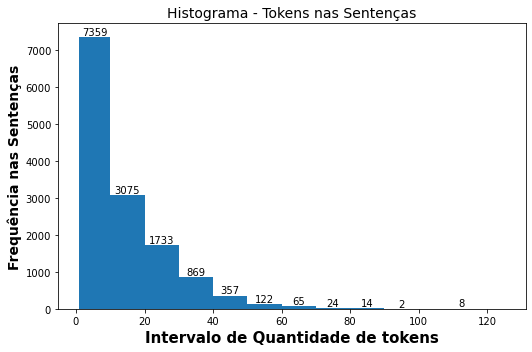

In [214]:
#plt.rcParams["figure.figsize"] = [7.0, 5.0]
#plt.rcParams["figure.autolayout"] = True

fig, axxx = plt.subplots(figsize=(7.5, 5.0))
bins_list = [1, 10, 20, 30, 40, 50,60,70,80,90,100,125]
axxx.hist(lista_tokens_por_sentenca, bins=bins_list)

for rect in axxx.patches:
    height = rect.get_height()
    axxx.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='center') 

plt.xlabel('Intervalo de Quantidade de tokens',fontweight='bold', fontsize=15)
plt.ylabel('Frequência nas Sentenças',fontweight='bold', fontsize=13.9)
plt.title('Histograma - Tokens nas Sentenças', fontsize=14.0) 
#plt.grid()
plt.savefig('31.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

### TOKENS POR DOCUMENTO

In [229]:
print('-------TOKENS POR DOCUMENTOS-----------')
print("-----QUANTIDADES-----")
print("Quantidade de Documentos: " + str(len(lista_tokens_por_inst)))
print("Quantidade de tokens: " + str(sum(lista_tokens_por_inst)))
print("Quantidade máxima de tokens em uma documento: " + str(max(lista_tokens_por_inst)))
print("Quantidade mínima de tokens em uma documento: " + str(min(lista_tokens_por_inst)))
print("-----Médias-----")
print("Média aritmética dos tokens por documento: " + str(statistics.mean(lista_tokens_por_inst)))
print("Média geométrica dos tokens por documento: " + str(statistics.geometric_mean(lista_tokens_por_inst)))
print("Média harmônica dos tokens por documento: " + str(statistics.harmonic_mean(lista_tokens_por_inst)))
print("-----Medianas-----")
print("Mediana dos tokens por documento: " + str(statistics.median(lista_tokens_por_inst)))
print("Mediana inferior dos tokens por documento: " + str(statistics.median_low(lista_tokens_por_inst)))
print("Mediana superior dos tokens por documento: " + str(statistics.median_high(lista_tokens_por_inst)))
print("Mediana, ou o 50º percentil dos dados agrupados dos tokens por documento: " + str(statistics.median_grouped(lista_tokens_por_inst)))
print("-----Moda-----")
print("Moda dos tokens por documento: " + str(statistics.mode(lista_tokens_por_inst)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional dos tokens por documento: " + str(statistics.pstdev(lista_tokens_por_inst)))
print("Desvio padrão amostral dos tokens por documento: " + str(statistics.stdev(lista_tokens_por_inst)))
print("-----Variância-----")
print("Variância populacional dos tokens por documento: " + str(statistics.pvariance(lista_tokens_por_inst)))
print("Variância amostral dos tokens por documento: " + str(statistics.variance(lista_tokens_por_inst)))
print("-----Quantiles-----")
print("Quantiles dos tokens por documento: " + str(statistics.quantiles(lista_tokens_por_inst)))
print("Variancia dos tokens por sentença: " + str(statistics.variance(lista_tokens_por_inst)))
print("Assimetria da quantidade de tokens por sentença: " + str(skew(lista_tokens_por_inst)))
print("Curtose da quantidade de tokens por documento: " + str(kurtosis(lista_tokens_por_inst)))

-------TOKENS POR DOCUMENTOS-----------
-----QUANTIDADES-----
Quantidade de Documentos: 1000
Quantidade de tokens: 183019
Quantidade máxima de tokens em uma documento: 974
Quantidade mínima de tokens em uma documento: 17
-----Médias-----
Média aritmética dos tokens por documento: 183.019
Média geométrica dos tokens por documento: 143.28836122656264
Média harmônica dos tokens por documento: 112.14275337083208
-----Medianas-----
Mediana dos tokens por documento: 140.5
Mediana inferior dos tokens por documento: 140
Mediana superior dos tokens por documento: 141
Mediana, ou o 50º percentil dos dados agrupados dos tokens por documento: 140.5
-----Moda-----
Moda dos tokens por documento: 175
-----Desvio Padrão-----
Desvio padrão populacional dos tokens por documento: 136.98065060073264
Desvio padrão amostral dos tokens por documento: 137.04919233662093
-----Variância-----
Variância populacional dos tokens por documento: 18763.698639
Variância amostral dos tokens por documento: 18782.48112012

#### Gráficos

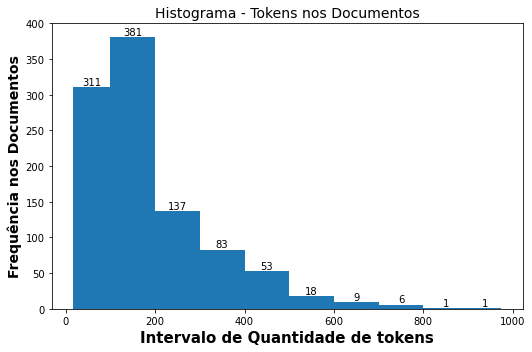

In [215]:
#plt.rcParams["figure.figsize"] = [7.0, 5.0]
#plt.rcParams["figure.autolayout"] = True

fig, axx = plt.subplots(figsize=(7.5, 5.0))
bins_list = [17, 100,200,300,400,500,600,700,800,900, 974]
axx.hist(lista_tokens_por_inst, bins=bins_list)

for rect in axx.patches:
    height = rect.get_height()
    axx.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='center') 
    
plt.xlabel('Intervalo de Quantidade de tokens',fontweight='bold', fontsize=15)
plt.ylabel('Frequência nos Documentos',fontweight='bold', fontsize=14.0)
plt.title('Histograma - Tokens nos Documentos', fontsize=14.0) 
#plt.grid()
plt.savefig('32.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

### SENTENÇAS POR DOCUMENTO

In [230]:
print('-------SENTENÇAS POR DOCUMENTOS-----------')
print("-----QUANTIDADES-----")
print("Quantidade de documentos: " + str(len(lista_sentencas_por_inst)))
print("Quantidade de sentenças: " + str(sum(lista_sentencas_por_inst)))
print("Quantidade máxima de sentenças em uma documento: " + str(max(lista_sentencas_por_inst)))
print("Quantidade mínima de sentenças em uma documento: " + str(min(lista_sentencas_por_inst)))
print("-----Médias-----")
print("Média aritmética das sentenças por documento: " + str(statistics.mean(lista_sentencas_por_inst)))
print("Média geométrica das sentenças por documento: " + str(statistics.geometric_mean(lista_sentencas_por_inst)))
print("Média harmônica das sentenças por documento: " + str(statistics.harmonic_mean(lista_sentencas_por_inst)))
print("-----Medianas-----")
print("Mediana das sentenças por documento: " + str(statistics.median(lista_sentencas_por_inst)))
print("Mediana inferior das sentenças por documento: " + str(statistics.median_low(lista_sentencas_por_inst)))
print("Mediana superior das sentenças por documento: " + str(statistics.median_high(lista_sentencas_por_inst)))
print("Mediana, ou o 50º percentil dos dados agrupados das sentenças por documento: " + str(statistics.median_grouped(lista_sentencas_por_inst)))
print("-----Moda-----")
print("Moda das sentenças por documento: " + str(statistics.mode(lista_sentencas_por_inst)))
print("-----Desvio Padrão-----")
print("Desvio padrão populacional das sentenças por documento: " + str(statistics.pstdev(lista_sentencas_por_inst)))
print("Desvio padrão amostral das sentenças por documento: " + str(statistics.stdev(lista_sentencas_por_inst)))
print("-----Variância-----")
print("Variância populacional das sentenças por documento: " + str(statistics.pvariance(lista_sentencas_por_inst)))
print("Variância amostral dos das sentenças documento: " + str(statistics.variance(lista_sentencas_por_inst)))
print("-----Quantiles-----")
print("Quantiles das sentenças por documento: " + str(statistics.quantiles(lista_sentencas_por_inst)))
print("Assimetria da quantidade de tokens por sentença: " + str(skew(lista_sentencas_por_inst)))
print("Curtose da quantidade de senteças por documento: " + str(kurtosis(lista_sentencas_por_inst)))

-------SENTENÇAS POR DOCUMENTOS-----------
-----QUANTIDADES-----
Quantidade de documentos: 1000
Quantidade de sentenças: 13628
Quantidade máxima de sentenças em uma documento: 45
Quantidade mínima de sentenças em uma documento: 3
-----Médias-----
Média aritmética das sentenças por documento: 13.628
Média geométrica das sentenças por documento: 11.76785482525102
Média harmônica das sentenças por documento: 10.10657256838058
-----Medianas-----
Mediana das sentenças por documento: 12.0
Mediana inferior das sentenças por documento: 12
Mediana superior das sentenças por documento: 12
Mediana, ou o 50º percentil dos dados agrupados das sentenças por documento: 11.741379310344827
-----Moda-----
Moda das sentenças por documento: 9
-----Desvio Padrão-----
Desvio padrão populacional das sentenças por documento: 7.386854269579169
Desvio padrão amostral das sentenças por documento: 7.390550469094723
-----Variância-----
Variância populacional das sentenças por documento: 54.565616
Variância amostra

#### Gráficos

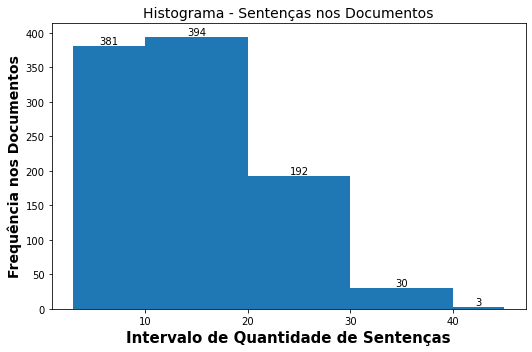

In [217]:
import numpy as np 
#plt.rcParams["figure.figsize"] = [7.0, 5.0]
#plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(figsize=(7.5, 5.0))
bins_list = [3, 10,20,30,40,45]
ax.hist(lista_sentencas_por_inst,bins = bins_list)
#plt.gca().xaxis.tick_top()
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='center') 

plt.xlabel('Intervalo de Quantidade de Sentenças',fontweight='bold', fontsize=15)
plt.ylabel('Frequência nos Documentos',fontweight='bold', fontsize=14.0)
plt.title('Histograma - Sentenças nos Documentos', fontsize=14.0) 
#plt.grid()
plt.savefig('33.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [222]:
def countOccurrence(a):
    k = {}
    for j in a:
        
        if j in k:
            k[j] +=1
        else:
            k[j] =1
    return k

retorno = countOccurrence(lista_tokens_por_sentenca)

In [223]:
retorno

{7: 589,
 6: 1497,
 8: 705,
 3: 1235,
 9: 661,
 18: 230,
 28: 133,
 16: 221,
 22: 204,
 12: 315,
 24: 189,
 13: 360,
 17: 208,
 20: 204,
 23: 174,
 4: 1485,
 48: 22,
 10: 570,
 21: 177,
 5: 887,
 11: 395,
 14: 280,
 32: 105,
 25: 158,
 33: 124,
 15: 255,
 45: 30,
 44: 33,
 27: 189,
 31: 109,
 47: 43,
 26: 179,
 54: 10,
 39: 74,
 19: 241,
 37: 64,
 29: 126,
 65: 12,
 66: 2,
 43: 30,
 36: 85,
 56: 12,
 49: 34,
 30: 118,
 40: 44,
 35: 82,
 46: 28,
 61: 8,
 53: 19,
 42: 45,
 50: 17,
 51: 11,
 34: 63,
 38: 45,
 41: 48,
 2: 148,
 1: 152,
 60: 5,
 52: 20,
 100: 2,
 105: 2,
 55: 14,
 83: 5,
 77: 4,
 64: 9,
 62: 13,
 72: 3,
 76: 6,
 58: 11,
 68: 4,
 57: 3,
 59: 5,
 63: 7,
 78: 3,
 84: 8,
 67: 3,
 70: 3,
 89: 1,
 75: 3,
 69: 2,
 71: 2,
 99: 1,
 91: 1,
 111: 1,
 125: 1,
 118: 1,
 101: 1}

In [228]:
lista_tokens_por_sentenca[2]

8